## Part 4: Modeling
For this part main goal is predict Ribbed Smoked Sheet in all business day in october 2022 and decrease mean absolute percentage error as low as possible.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.var import VAR
from sklearn.preprocessing import StandardScaler
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.tbats import TBATS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Function

In [15]:
def import_csv_dateindex(csv_file):
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('B')
    return df

In [16]:
def compare_value(y_test, preds, title=None):
    
    df = pd.concat([y_test, preds], axis=1)
    df.columns = ['true', 'preds']
    
    fig = go.Figure(layout = go.Layout(template='ggplot2'))

    fig.add_scatter(x=df.index, y=df['true'], line={'dash':'dash', 'color':'dodgerblue'}, name='True')
    fig.add_scatter(x=df.index, y=df['preds'], line={'color':'red'}, name='Predict')

    fig.update_layout(title=go.layout.Title(
            text=f"{title}<br><sup>MAPE is {round(mean_absolute_percentage_error(df['true'], df['preds'])*100, 2)}%</sup>\
            <br><sup>RMSE is {round(mean_squared_error(y_test, preds, square_root=True), 2)}<sup>",
            xref="paper",
            x=0))

    fig.show()

## Models

In [220]:
# import dataset from EDA part
rubber = import_csv_dateindex('../data/rubber.csv')
rubber = rubber.loc['2022':]
rubber.head()

,cup_lump,rubber_sheet,ribbed_smoked_sheet,latex,fob,tocom,sicom,jpy,sgd,usd,crude_oil
date,,,,,,,,,,,
2022-01-03,46.5,53.88,56.13,48.0,63.90,222.8,196.5,3.4672,24.5477,0.0301,71.11
2022-01-04,46.5,53.88,57.15,49.0,64.20,224.7,196.7,3.4905,24.5188,0.0301,72.11
2022-01-05,47.0,53.64,57.56,51.5,64.75,229.0,197.5,3.4959,24.4422,0.0301,72.23
2022-01-06,47.5,54.40,58.20,52.8,64.40,224.0,193.5,3.4501,24.6510,0.0298,72.97
2022-01-07,47.5,54.64,57.82,53.0,64.50,226.0,196.4,3.4349,24.7935,0.0297,72.66


### Baseline Model
for baseline model will use ARIMA(AR = 1, I = 1, MA = 1) for predicting. (I(d) set to 1 for make target to be stationary)

In [87]:
# split train and test
y_train = rubber['ribbed_smoked_sheet'].loc[:'2022-08']
y_test = rubber['ribbed_smoked_sheet'].loc['2022-09':]

In [88]:
# check that split working correctly
y_train.tail().index, y_test.head().index

(DatetimeIndex(['2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30',
                '2022-08-31'],
               dtype='datetime64[ns]', name='date', freq='B'),
 DatetimeIndex(['2022-09-01', '2022-09-02', '2022-09-05', '2022-09-06',
                '2022-09-07'],
               dtype='datetime64[ns]', name='date', freq='B'))

In [89]:
y_test.index[-1]

Timestamp('2022-10-31 00:00:00', freq='B')

In [94]:
arima = ARIMA(order=(2, 1, 1))
arima.fit(y_train)
preds = arima.predict(fh=y_test.index)

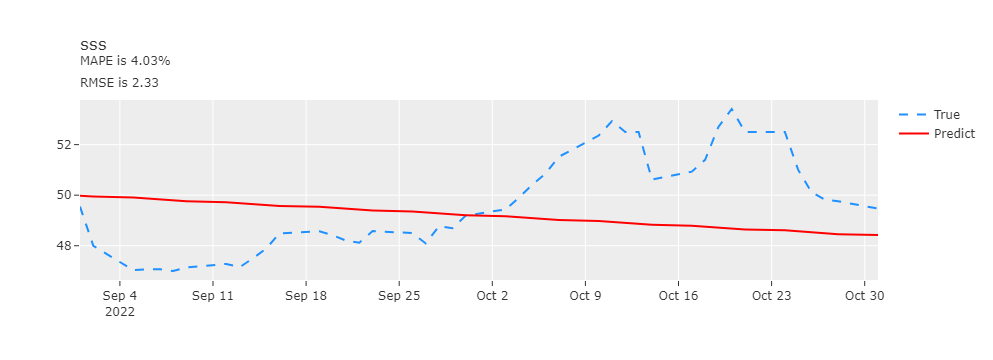

In [95]:
compare_value(y_test, preds, 'sss')

### Add features
using exogenous for predicting Ribbed Smoked Sheet need to lag for 1 month.

#### Rubber types

In [103]:
rubber_sheet = rubber[['ribbed_smoked_sheet']].copy()
rubber_sheet['rubber_sheet_lag'] = rubber['rubber_sheet'].shift(3, freq='B').copy()
rubber_sheet.dropna(inplace=True)

In [104]:
rubber['rubber_sheet'].loc['2022-09'].tail(), rubber_sheet['rubber_sheet_lag'].tail()

(date
 2022-09-26    45.64
 2022-09-27    45.66
 2022-09-28    46.04
 2022-09-29    46.16
 2022-09-30    46.51
 Freq: B, Name: rubber_sheet, dtype: float64,
 date
 2022-10-25    49.01
 2022-10-26    49.10
 2022-10-27    49.10
 2022-10-28    48.58
 2022-10-31    48.72
 Freq: B, Name: rubber_sheet_lag, dtype: float64)

In [105]:
# split train and test
X_train = rubber_sheet['rubber_sheet_lag'].loc[:'2022-08']
X_test = rubber_sheet['rubber_sheet_lag'].loc['2022-09':]
y_train = rubber_sheet['ribbed_smoked_sheet'].loc[:'2022-08']
y_test = rubber_sheet['ribbed_smoked_sheet'].loc['2022-09':]

From pattern above I can create function for reduce redundant code.

In [106]:
def train_test_lagged(df, endog:'series', exog:'li', shift, before_pred_date:'date', pred_date:'date'):
    df_lag = df[[endog]].copy()
    for col in exog:
        df_lag[col] = df[col].shift(shift, freq='B').copy()
    df_lag.dropna(inplace=True)
    
    X_train = df_lag[exog].loc[:before_pred_date]
    X_test = df_lag[exog].loc[pred_date:]
    y_train = df_lag[endog].loc[:before_pred_date]
    y_test = df_lag[endog].loc[pred_date:]
    
    return X_train, X_test, y_train, y_test

In [107]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['rubber_sheet', 'latex', 'cup_lump'],
                                                     3, '2022-08', '2022-09')

In [120]:
def pred_arima(y_train, y_test, order, X_train=None, X_test=None, title=None):
    arima = ARIMA(order=order, seasonal_order=(1,1,1,4))
    arima.fit(y_train, X_train)
    preds = arima.predict(fh=y_test.index, X=X_test)

    compare_value(y_test, preds, title)

    return arima

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

D:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



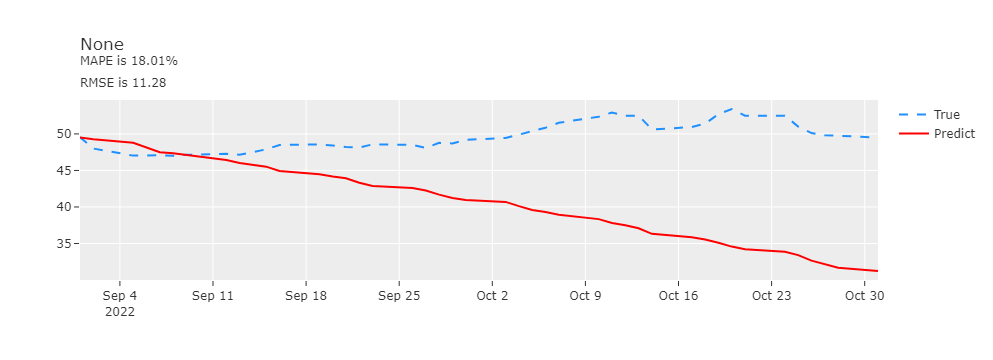

ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1, 4))

In [121]:
pred_arima(y_train, y_test, (2, 1, 1), X_train, X_test)

#### Futures

In [98]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['tocom', 'sicom'],
                                                     41, '2022-08', '2022-09')

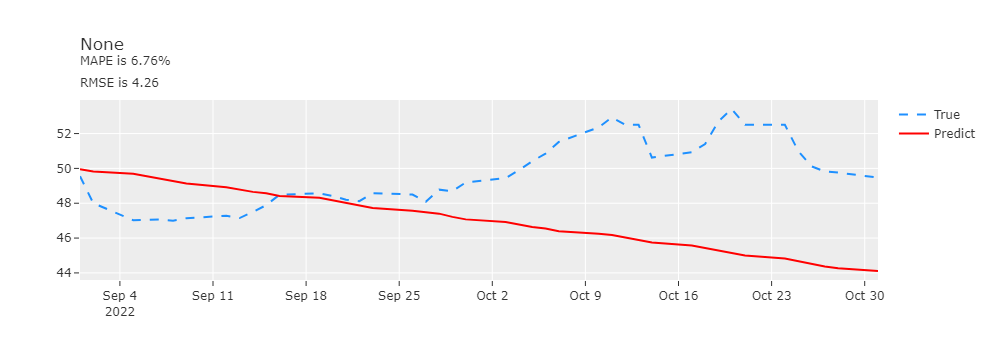

ARIMA(order=(1, 1, 1))

In [102]:
pred_arima(y_train, y_test, (1, 1, 1), X_train, X_test)

#### Currencies

In [57]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['jpy', 'sgd', 'usd'],
                                                     41, '2022-08', '2022-09')

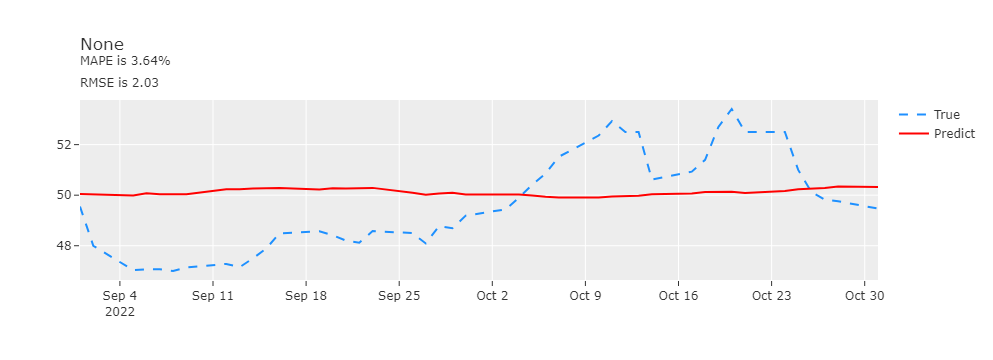

ARIMA(order=(1, 1, 1))

In [58]:
pred_arima(y_train, y_test, (1, 1, 1), X_train, X_test)

#### oil

In [59]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet', ['crude_oil'],
                                                     41, '2022-08', '2022-09')

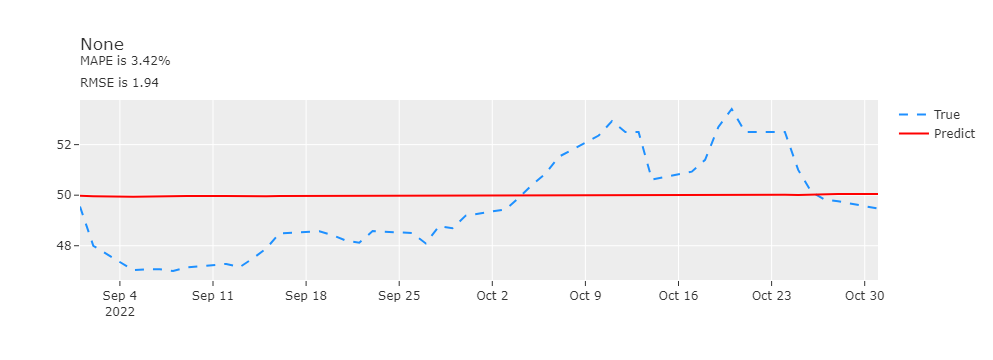

ARIMA(order=(1, 1, 1))

In [60]:
pred_arima(y_train, y_test, (1, 1, 1), X_train, X_test)

In [81]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet',
                                                     rubber[['rubber_sheet', 'latex', 'tocom', 'sicom']].columns,
                                                     41, '2022-08-30', '2022-09')

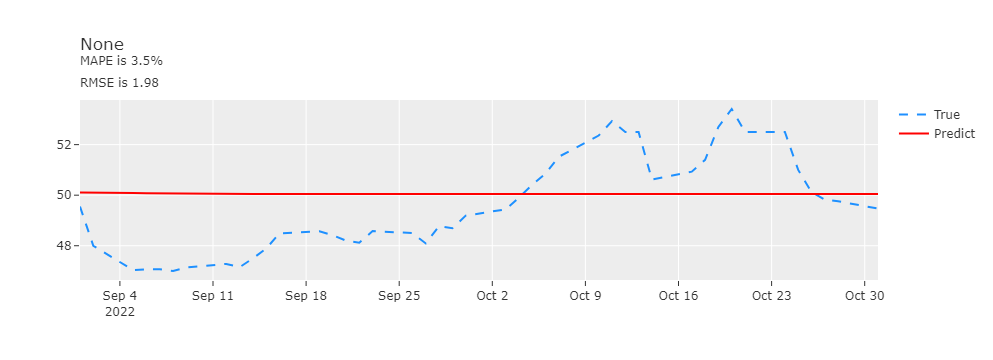

In [84]:
tbats = TBATS(  
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=[5, 30],
    use_arma_errors=True,
    n_jobs=1)
tbats.fit(y_train, X_train)
preds = tbats.predict(y_test.index, X_test)

compare_value(y_test, preds)

### LSTM

In [271]:
X_train, X_test, y_train, y_test = train_test_lagged(rubber, 'ribbed_smoked_sheet',
                                                     rubber[['tocom', 'sicom']].columns,
                                                     12, '2022-08-30', '2022-09')

In [272]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [273]:
X_train_sc.shape

(160, 2)

In [274]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=4)

In [275]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=4)

In [294]:
es = EarlyStopping(patience=20)
# Design RNN
model = Sequential()

# input layer
model.add(LSTM(4, activation='relu', input_shape=(3, 2), return_sequences=True))
# # return sequences = True if the next layer is RNN (GRU)
# # return sequences = False if the next layer is Dense
model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='elu', return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
# # outer layer
model.add(Dense(1, activation=None))

#compile
model.compile(loss='mae', optimizer=Adam(learning_rate=0.001), metrics=['mape'])

# fit
history = model.fit(train_sequences, validation_data=test_sequences, epochs=150, callbacks=[es])

Epoch 1/150
40/40 [==============================] - 5s 21ms/step - loss: 64.0456 - mape: 99.7663 - val_loss: 49.3895 - val_mape: 99.3557
Epoch 2/150
40/40 [==============================] - 0s 7ms/step - loss: 63.6908 - mape: 99.2062 - val_loss: 48.9804 - val_mape: 98.5316
Epoch 3/150
40/40 [==============================] - 0s 7ms/step - loss: 63.2279 - mape: 98.4732 - val_loss: 48.4591 - val_mape: 97.4814
Epoch 4/150
40/40 [==============================] - 0s 6ms/step - loss: 62.6559 - mape: 97.5743 - val_loss: 47.8182 - val_mape: 96.1902
Epoch 5/150
40/40 [==============================] - 0s 6ms/step - loss: 61.9543 - mape: 96.4759 - val_loss: 47.0537 - val_mape: 94.6499
Epoch 6/150
40/40 [==============================] - 0s 6ms/step - loss: 61.1305 - mape: 95.1737 - val_loss: 46.1631 - val_mape: 92.8556
Epoch 7/150
40/40 [==============================] - 0s 6ms/step - loss: 60.1819 - mape: 93.6827 - val_loss: 45.1450 - val_mape: 90.8044
Epoch 8/150
40/40 [=====================

<AxesSubplot:>

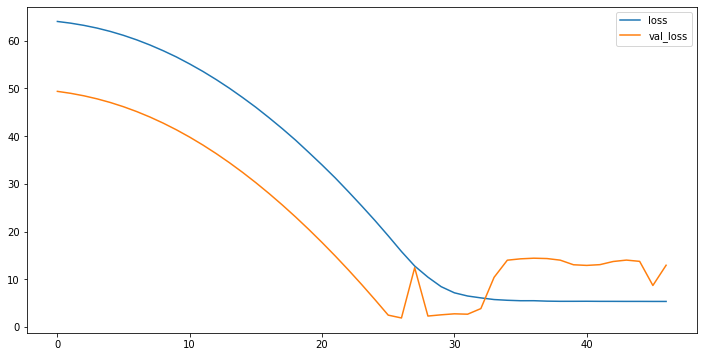

In [295]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(12,6))

In [296]:
y_test.index
len(preds)

40

In [297]:
preds = model.predict(test_sequences)

10/10 [==============================] - 1s 3ms/step


In [298]:
pred_df = pd.DataFrame(y_test)
pred_df = pred_df.iloc[3:]
pred_df = pd.concat([pred_df, pd.DataFrame(preds, columns=['preds'], index=y_test.iloc[3:].index)], axis=1)

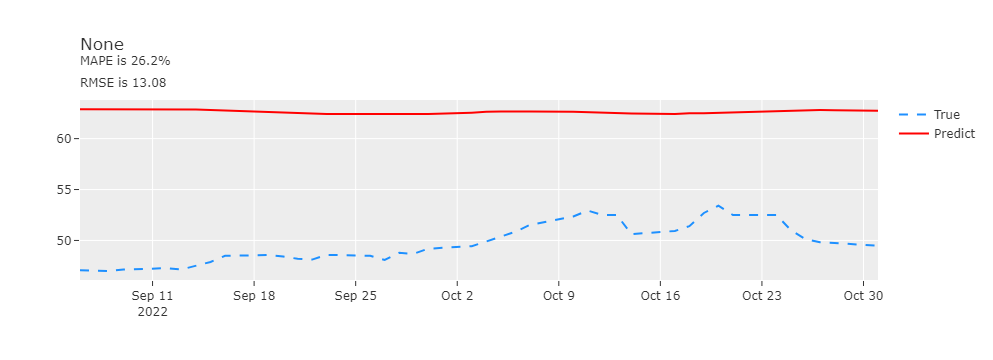

In [299]:
compare_value(pred_df['ribbed_smoked_sheet'], pred_df['preds'])

In [259]:
8

8